<a href="https://colab.research.google.com/github/dbamman/nlp21/blob/main/HW3/HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Pytorch and CNNs

In this homework, you will begin exploring Pytorch, a neural network library that will be used throughout the remainder of the semester.  This homework will focus on Convolutional Neural Networks.



In [1]:
import sys, argparse
import numpy as np
import re
import nltk
import csv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import nltk
from tqdm import tqdm
from collections import Counter

#Sets random seeds for reproducibility
seed=159259
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
!python -m nltk.downloader punkt

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


When looking up pytorch documentation, it may be useful to know which version of torch you are running.


In [3]:
print(torch.__version__)

1.7.0+cu101


# **IMPORTANT**: GPU is not enabled by default

You must switch runtime environments if your output of the next block of code has an error saying "ValueError: Expected a cuda device, but got: cpu"

Go to Runtime > Change runtime type > Hardware accelerator > GPU

In [4]:
device = torch.cuda.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on <torch.cuda.device object at 0x7f54d63a7cf8>


# Data Processing

Let's begin by loading our datasets and the 50-dimensional GLoVE word embeddings.  

In [5]:
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW3/acl.train
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW3/acl.dev
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW3/glove.6B.50d.50K.txt

--2021-02-10 20:52:47--  https://raw.githubusercontent.com/dbamman/nlp21/main/HW3/acl.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1027009 (1003K) [text/plain]
Saving to: ‘acl.train’

acl.train           100%[===================>]   1003K  --.-KB/s    in 0.02s   

2021-02-10 20:52:47 (50.2 MB/s) - ‘acl.train’ saved [1027009/1027009]

--2021-02-10 20:52:47--  https://raw.githubusercontent.com/dbamman/nlp21/main/HW3/acl.dev
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 359826 (351K) [text/plain]
Saving to: ‘acl.dev’

acl.

In [6]:
trainingFile = "acl.train"
devFile = "acl.dev"

In [7]:
labels = {'APPLICATIONS': 11,
 'CSSCA': 23,
 'DIALOGUE': 12,
 'DISCOURSE': 13,
 'ETHICS': 8,
 'GENERATION': 9,
 'GREEN': 15,
 'GROUNDING': 18,
 'IE': 6,
 'INTERPRET': 10,
 'IR': 22,
 'LEXSEM': 7,
 'LING': 24,
 'MLCLASS': 1,
 'MLLM': 16,
 'MT': 4,
 'MULTILING': 3,
 'OTHER': 25,
 'PHON': 5,
 'QA': 17,
 'RESOURCES': 14,
 'SA': 21,
 'SENTSEM': 0,
 'SPEECH': 19,
 'SUMM': 2,
 'SYNTAX': 20}

In [8]:
def get_batches(x, y, xType, batch_size=12):
    batches_x=[]
    batches_y=[]
    for i in range(0, len(x), batch_size):
        batches_x.append(xType(x[i:i+batch_size]))
        batches_y.append(torch.LongTensor(y[i:i+batch_size]))
    
    return batches_x, batches_y
        

In [9]:
PAD_INDEX = 0             # reserved for padding words
UNKNOWN_INDEX = 1         # reserved for unknown words
SEP_INDEX = 2

data_lens = []

def read_embeddings(filename, vocab_size=50000):
  """
  Utility function, loads in the `vocab_size` most common embeddings from `filename`
  
  Arguments:
  - filename:     path to file
                  automatically infers correct embedding dimension from filename
  - vocab_size:   maximum number of embeddings to load

  Returns 
  - embeddings:   torch.FloatTensor matrix of size (vocab_size x word_embedding_dim)
  - vocab:        dictionary mapping word (str) to index (int) in embedding matrix
  """

  # get the embedding size from the first embedding
  with open(filename, encoding="utf-8") as file:
    word_embedding_dim = len(file.readline().split(" ")) - 1

  vocab = {}

  embeddings = np.zeros((vocab_size, word_embedding_dim))
  with open(filename, encoding="utf-8") as file:
    for idx, line in enumerate(file):

      if idx + 2 >= vocab_size:
        break

      cols = line.rstrip().split(" ")
      val = np.array(cols[1:])
      word = cols[0]
      embeddings[idx + 2] = val
      vocab[word] = idx + 2
  
  # a FloatTensor is a multidimensional matrix
  # that contains 32-bit floats in every entry
  # https://pytorch.org/docs/stable/tensors.html
  return torch.FloatTensor(embeddings), vocab




# Logistic regression

First, let's code up logistic regression in pytorch so you can see how the general framework works, and also get a sense of baseline performance that we can compare a CNN against.

In [10]:
def get_vocab(filename, max_words=10000):
    unigram_counts=Counter()
    with open(filename) as file:    
        for line in file:
            cols=line.rstrip().split("\t")
            idd = cols[0]
            label = cols[1]
            title = cols[2]
            abstract = cols[3]
            strr="%s %s" % (title, abstract)
            words=nltk.word_tokenize(strr)

            for word in words:
                word=word.lower()
                unigram_counts[word]+=1 # key as word, value as counts

    vocab={}
    for k,v in unigram_counts.most_common(max_words): # top max_words words, k as word, v as counts
        vocab[k]=len(vocab) # key as word, value as top rank
    return vocab
        

In [11]:
class LogisticRegressionClassifier(nn.Module):

   def __init__(self, input_dim, output_dim):
      super().__init__()
      self.linear = torch.nn.Linear(input_dim, output_dim)
 
    
   def forward(self, input): 
      x1 = self.linear(input)
      return x1

   def evaluate(self, x, y):
      self.eval()
      corr = 0.
      total = 0.
      with torch.no_grad():
        for x, y in zip(x, y):
          y_preds=self.forward(x)
          for idx, y_pred in enumerate(y_preds):
              prediction=torch.argmax(y_pred)
              if prediction == y[idx]:
                corr += 1.
              total+=1                          
      return corr/total



## Average Embedding Representation
Let's train a logistic regression classifier where the input is the average GLoVE embedding for all words in a paper's title and abstract

In [12]:
def read_glove_data(filename, vocab, embs):
    data=[]
    data_labels=[]
    with open(filename) as file:
        for line in file:
            avg_emb=np.zeros(50)
            cols=line.rstrip().split("\t")
            idd = cols[0]
            label = cols[1]
            title = cols[2]
            abstract = cols[3]
            strr="%s %s" % (title, abstract)
            words=nltk.word_tokenize(strr)
            avg_counter = 0.
            for word in words:
                word=word.lower()
                if word in glove_vocab:
                    avg_emb += embs[glove_vocab[word]].numpy()
                    avg_counter += 1.
            avg_emb /= avg_counter

            data.append(avg_emb)
            data_labels.append(labels[label])
    return data, data_labels 

In [13]:
embs, glove_vocab = read_embeddings("glove.6B.50d.50K.txt")
avg_train_x, avg_train_y=read_glove_data(trainingFile, glove_vocab, embs)
avg_dev_x, avg_dev_y=read_glove_data(devFile, glove_vocab, embs)

In [14]:
avg_trainX, avg_trainY=get_batches(avg_train_x, avg_train_y, xType=torch.FloatTensor)
avg_devX, avg_devY=get_batches(avg_dev_x, avg_dev_y, xType=torch.FloatTensor)

In [15]:
logreg=LogisticRegressionClassifier(50, len(labels))
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001, weight_decay=1e-5)
losses = []
cross_entropy=nn.CrossEntropyLoss()

num_labels=len(labels)

for epoch in range(200):
    logreg.train()
    
    for x, y in zip(avg_trainX, avg_trainY):
        y_pred=logreg.forward(x)
        loss = cross_entropy(y_pred.view(-1, num_labels), y.view(-1))
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    dev_accuracy=logreg.evaluate(avg_devX, avg_devY)
    if epoch % 5 == 0:
        print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))


Epoch 0, dev accuracy: 0.080
Epoch 5, dev accuracy: 0.097
Epoch 10, dev accuracy: 0.140
Epoch 15, dev accuracy: 0.177
Epoch 20, dev accuracy: 0.200
Epoch 25, dev accuracy: 0.206
Epoch 30, dev accuracy: 0.220
Epoch 35, dev accuracy: 0.229
Epoch 40, dev accuracy: 0.231
Epoch 45, dev accuracy: 0.237
Epoch 50, dev accuracy: 0.240
Epoch 55, dev accuracy: 0.246
Epoch 60, dev accuracy: 0.251
Epoch 65, dev accuracy: 0.260
Epoch 70, dev accuracy: 0.266
Epoch 75, dev accuracy: 0.263
Epoch 80, dev accuracy: 0.266
Epoch 85, dev accuracy: 0.266
Epoch 90, dev accuracy: 0.266
Epoch 95, dev accuracy: 0.266
Epoch 100, dev accuracy: 0.263
Epoch 105, dev accuracy: 0.263
Epoch 110, dev accuracy: 0.269
Epoch 115, dev accuracy: 0.271
Epoch 120, dev accuracy: 0.274
Epoch 125, dev accuracy: 0.277
Epoch 130, dev accuracy: 0.277
Epoch 135, dev accuracy: 0.277
Epoch 140, dev accuracy: 0.289
Epoch 145, dev accuracy: 0.297
Epoch 150, dev accuracy: 0.303
Epoch 155, dev accuracy: 0.306
Epoch 160, dev accuracy: 0.314

## BOW Representation
Feel free to fill in your bag-of-words implementation into read_bow_data() to see how the logistic classifier model works with a different featurization.  (You are not required to do anything within this BOW representation section; we provide the structure in case you'd like to explore how your your BOW logistic regression model from the last homework could be implemented in Pytorch).

In [16]:
def read_bow_data(filename, vocab):
    data=[]
    data_labels=[]
    with open(filename) as file:
        for line in file:
            cols=line.rstrip().split("\t")
            idd = cols[0]
            label = cols[1]
            title = cols[2]
            abstract = cols[3]
            strr="%s %s" % (title, abstract)
            bow=np.zeros(len(vocab))

            '''
            Insert your bow code here to store the featurization in the bow variable 
            '''
            words = nltk.word_tokenize(strr)
            for word in words:
              word = word.lower()
              if word in vocab:
                bow[vocab[word]] = 1

            data.append(bow)

            data_labels.append(labels[label])
    return data, data_labels 


In [17]:
bow_vocab=get_vocab(trainingFile)
bow_train_x, bow_train_y=read_bow_data(trainingFile, bow_vocab)
bow_dev_x, bow_dev_y=read_bow_data(devFile, bow_vocab)

In [18]:
bow_trainX, bow_trainY=get_batches(bow_train_x, bow_train_y, xType=torch.FloatTensor)
bow_devX, bow_devY=get_batches(bow_dev_x, bow_dev_y, xType=torch.FloatTensor)

In [19]:
logreg=LogisticRegressionClassifier(len(bow_vocab), len(labels))
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001, weight_decay=1e-5)
losses = []
cross_entropy=nn.CrossEntropyLoss()

num_labels=len(labels)

for epoch in range(200):
    for x, y in zip(bow_trainX, bow_trainY):
        y_pred=logreg.forward(x)
        loss = cross_entropy(y_pred.view(-1, num_labels), y.view(-1))
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    dev_accuracy=logreg.evaluate(bow_devX, bow_devY)
    if epoch % 5 == 0:
        print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))


Epoch 0, dev accuracy: 0.263
Epoch 5, dev accuracy: 0.389
Epoch 10, dev accuracy: 0.397
Epoch 15, dev accuracy: 0.409
Epoch 20, dev accuracy: 0.409
Epoch 25, dev accuracy: 0.406
Epoch 30, dev accuracy: 0.406
Epoch 35, dev accuracy: 0.411
Epoch 40, dev accuracy: 0.409
Epoch 45, dev accuracy: 0.414
Epoch 50, dev accuracy: 0.420
Epoch 55, dev accuracy: 0.423
Epoch 60, dev accuracy: 0.426
Epoch 65, dev accuracy: 0.429
Epoch 70, dev accuracy: 0.434
Epoch 75, dev accuracy: 0.434
Epoch 80, dev accuracy: 0.440
Epoch 85, dev accuracy: 0.437
Epoch 90, dev accuracy: 0.440
Epoch 95, dev accuracy: 0.440
Epoch 100, dev accuracy: 0.449
Epoch 105, dev accuracy: 0.449
Epoch 110, dev accuracy: 0.449
Epoch 115, dev accuracy: 0.460
Epoch 120, dev accuracy: 0.457
Epoch 125, dev accuracy: 0.463
Epoch 130, dev accuracy: 0.463
Epoch 135, dev accuracy: 0.463
Epoch 140, dev accuracy: 0.469
Epoch 145, dev accuracy: 0.471
Epoch 150, dev accuracy: 0.474
Epoch 155, dev accuracy: 0.471
Epoch 160, dev accuracy: 0.483

# Deliverable 1. CNN 

Now let's create our CNN.

In [20]:
def read_data(filename, vocab, labels):
    """
    :param filename: the name of the file
    :return: list of tuple ([word index list], label)
    as input for the forward and backward function
    """    
    data = []
    data_labels = []
    file = open(filename)
    for line in file:
        cols = line.split("\t")
        idd = cols[0]
        label = cols[1]
        title = cols[2]
        abstract = cols[3]
        w_int = []
        for w in nltk.word_tokenize(title.lower()):
            if w in vocab:
                w_int.append(vocab[w])
            else:
                w_int.append(UNKNOWN_INDEX)
        w_int.append(SEP_INDEX)
        w_int.append(SEP_INDEX)
        for w in nltk.word_tokenize(abstract.lower()):
            if w in vocab:
                w_int.append(vocab[w])
            else:
                w_int.append(UNKNOWN_INDEX)
        data_lens.append(len(w_int))
        if len(w_int) < 549:
            w_int.extend([PAD_INDEX] * (549 - len(w_int)))
        if len(w_int) < 550:
          data.append((w_int))
          data_labels.append(labels[label])
    file.close()
    return data, data_labels

In [21]:
embs, cnn_vocab = read_embeddings("glove.6B.50d.50K.txt")

In [22]:
embs.shape

torch.Size([50000, 50])

In [23]:
cnn_train_x, cnn_train_y = read_data(trainingFile, cnn_vocab, labels)
cnn_dev_x, cnn_dev_y = read_data(devFile, cnn_vocab, labels)

In [24]:
cnn_trainX, cnn_trainY=get_batches(cnn_train_x, cnn_train_y, torch.LongTensor)
cnn_devX, cnn_devY=get_batches(cnn_dev_x, cnn_dev_y, torch.LongTensor)


In [57]:
class CNNClassifier(nn.Module):

   def __init__(self, params, pretrained_embeddings):
      super().__init__()
      self.seq_len = params["max_seq_len"]
      self.num_labels = params["label_length"]
      
      '''
      Initialize the following layers according to the hw spec
      '''
      self.embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
      
      # convolution over 1 word
      self.conv_1 = nn.Conv1d(in_channels=50, out_channels=50, kernel_size=1, stride=1)
      self.pool_1 = nn.MaxPool1d(kernel_size=549)

      # convolution over 2 words    
      self.conv_2 = nn.Conv1d(in_channels=50, out_channels=50, kernel_size=2, stride=1)
      self.pool_2 = nn.MaxPool1d(kernel_size=548)
        
      # convolution over 3 words
      self.conv_3 = nn.Conv1d(in_channels=50, out_channels=50, kernel_size=3, stride=1)
      self.pool_3 = nn.MaxPool1d(kernel_size=547)
      
      # fully-connected layer
      self.fc = nn.Linear(50*3, self.num_labels)


    
   def forward(self, input): 
      #embeds the input sequences
      x0 = self.embeddings(input)
      #changes dimensions to be consistent with conv1d
      #from (batch, length, dimensions) to (batch, dimensions, length)
      x0 = x0.permute(0, 2, 1)

      '''
      Create the hidden representations according to the hw spec
      '''
      #Apply the one-word convolution, tanh, and pool
      x1 = torch.tanh(self.conv_1(x0)) # 12, 50, 529
      # print('x1 size:', x1.shape)
      x1 = self.pool_1(x1) # 12, 50, 1
      # print('x1 size:', x1.shape)
    
      #Apply the two-word convolution, tanh, and pool
      x2 = torch.tanh(self.conv_2(x0)) # 12, 50, 528
      # print('x2 size:', x2.shape)
      x2 = self.pool_2(x2) # 12, 50, 1
      # print('x2 size:', x2.shape)
        
      #Apply the three-word convolution, tanh, and pool
      x3 = torch.tanh(self.conv_3(x0)) # 12, 50, 527
      # print('x3 size:', x3.shape)
      x3 = self.pool_3(x3) # 12, 50, 1
      # print('x3 size:', x3.shape)

      #Concatenates the output of all 3 convolution layers
      combined= torch.cat([x1, x2, x3], axis= 1) # 12, 150, 1
      combined = combined.permute(0,2,1) # 12, 1, 150
      # print('combined size:', combined.shape)

      #Connects the combined output to the fully-connected layer
      out = self.fc(combined)
      return out.squeeze()

   def evaluate(self, x, y):
      
      self.eval()
      corr = 0.
      total = 0.

      with torch.no_grad():

        for x, y in zip(x, y):
          y_preds=self.forward(x)
          for idx, y_pred in enumerate(y_preds):
              prediction=torch.argmax(y_pred)
              if prediction == y[idx]:
                corr += 1.
              total+=1                          
      return corr/total



In [58]:
embs, cnn_vocab = read_embeddings("glove.6B.50d.50K.txt")
cnnmodel = CNNClassifier(params={"max_seq_len": 549, "label_length": len(labels)}, pretrained_embeddings=embs)
optimizer = torch.optim.Adam(cnnmodel.parameters(), lr=0.001, weight_decay=1e-5)
losses = []
cross_entropy=nn.CrossEntropyLoss()

num_epochs=25
best_dev_acc = 0.

for epoch in range(num_epochs):
    cnnmodel.train()

    for x, y in zip(cnn_trainX, cnn_trainY):
      y_pred = cnnmodel.forward(x)
      loss = cross_entropy(y_pred.view(-1, cnnmodel.num_labels), y.view(-1))
      losses.append(loss) 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    dev_accuracy=cnnmodel.evaluate(cnn_devX, cnn_devY)
    if epoch % 1 == 0:
        print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
        if dev_accuracy > best_dev_acc:
          torch.save(cnnmodel.state_dict(), 'best-cnnmodel-parameters.pt')
          best_dev_acc = dev_accuracy

cnnmodel.load_state_dict(torch.load('best-cnnmodel-parameters.pt'))
print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))

Epoch 0, dev accuracy: 0.131
Epoch 1, dev accuracy: 0.180
Epoch 2, dev accuracy: 0.271
Epoch 3, dev accuracy: 0.343
Epoch 4, dev accuracy: 0.360
Epoch 5, dev accuracy: 0.374
Epoch 6, dev accuracy: 0.389
Epoch 7, dev accuracy: 0.414
Epoch 8, dev accuracy: 0.423
Epoch 9, dev accuracy: 0.440
Epoch 10, dev accuracy: 0.446
Epoch 11, dev accuracy: 0.449
Epoch 12, dev accuracy: 0.449
Epoch 13, dev accuracy: 0.457
Epoch 14, dev accuracy: 0.460
Epoch 15, dev accuracy: 0.451
Epoch 16, dev accuracy: 0.457
Epoch 17, dev accuracy: 0.460
Epoch 18, dev accuracy: 0.460
Epoch 19, dev accuracy: 0.474
Epoch 20, dev accuracy: 0.471
Epoch 21, dev accuracy: 0.469
Epoch 22, dev accuracy: 0.474
Epoch 23, dev accuracy: 0.474
Epoch 24, dev accuracy: 0.469

Best Performing Model achieves dev accuracy of : 0.474


# Model Exploration

## Loss Examination
To debug your model and ensure it is updating correctly, it may be helpful to visualize your training loss.  The following code plots loss over epoch.  This should decrease as the model trains and eventually converge.  If your training loss is not decreasing, you might not be initializing your model or creating your forward() pass correctly.

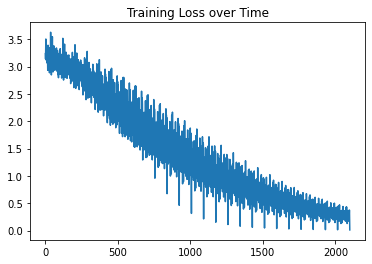

In [59]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.title("Training Loss over Time")
plt.show()

# Deliverable 2: Explore NLP articles
Now that you have your CNN trained, let's go ahead and make predictions for all of the 7,188 abstracts in our full dataset of NLP papers published between 2013-2020. 

In [60]:
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW3/acl.all.tsv

--2021-02-10 21:25:59--  https://raw.githubusercontent.com/dbamman/nlp21/main/HW3/acl.all.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7388302 (7.0M) [text/plain]
Saving to: ‘acl.all.tsv’

acl.all.tsv         100%[===================>]   7.05M  --.-KB/s    in 0.07s   

2021-02-10 21:25:59 (100 MB/s) - ‘acl.all.tsv’ saved [7388302/7388302]



In [61]:
def read_prediction_data(filename, vocab):
    """
    :param filename: the name of the file
    :return: list of tuple ([word index list], label)
    as input for the forward and backward function
    """    
    data = []
    data_dates = []
    file = open(filename)
    for line in file:
        cols = line.split("\t")
        idd = cols[0]
        year = int(cols[1])
        title = cols[2]
        abstract = cols[3]
        w_int = []
        for w in nltk.word_tokenize(title.lower()):
            # skip the unknown words
            if w in vocab:
                w_int.append(vocab[w])
            else:
                w_int.append(UNKNOWN_INDEX)
        w_int.append(SEP_INDEX)
        w_int.append(SEP_INDEX)
        for w in nltk.word_tokenize(abstract.lower()):
            # skip the unknown words
            if w in vocab:
                w_int.append(vocab[w])
            else:
                w_int.append(UNKNOWN_INDEX)
        data_lens.append(len(w_int))
        if len(w_int) < 549:
            w_int.extend([PAD_INDEX] * (549 - len(w_int)))
        if len(w_int) < 550:
          data.append((w_int))
          data_dates.append(year)
    file.close()
    return data, data_dates

In [62]:
predictFile="acl.all.tsv"
cnn_test_x, cnn_test_dates = read_prediction_data(predictFile, cnn_vocab)
cnn_predictX, cnn_predictDates=get_batches(cnn_test_x, cnn_test_dates, torch.LongTensor, batch_size=256)

In [63]:
reverse_labels={labels[k]:k for k in labels}

In [118]:
reverse_labels

{0: 'SENTSEM',
 1: 'MLCLASS',
 2: 'SUMM',
 3: 'MULTILING',
 4: 'MT',
 5: 'PHON',
 6: 'IE',
 7: 'LEXSEM',
 8: 'ETHICS',
 9: 'GENERATION',
 10: 'INTERPRET',
 11: 'APPLICATIONS',
 12: 'DIALOGUE',
 13: 'DISCOURSE',
 14: 'RESOURCES',
 15: 'GREEN',
 16: 'MLLM',
 17: 'QA',
 18: 'GROUNDING',
 19: 'SPEECH',
 20: 'SYNTAX',
 21: 'SA',
 22: 'IR',
 23: 'CSSCA',
 24: 'LING',
 25: 'OTHER'}

Now let's make predictions on all of that data with your trained `cnnmodel`.

In [64]:
with torch.no_grad():

  all_dates=[]
  all_preds=[]
  for x, y in zip(cnn_predictX, cnn_predictDates):
    y_preds=cnnmodel.forward(x)
    for idx, y_pred in enumerate(y_preds):
        prediction=int(torch.argmax(y_pred))
        all_dates.append(int(y[idx]))
        all_preds.append(prediction)

What are the most frequent categories among our predictions?

In [65]:
from collections import Counter
cat_counts=Counter()
for val in all_preds:
  cat_counts[val]+=1

for k,v in cat_counts.most_common():
  print(v, reverse_labels[k])

654 MT
599 SENTSEM
558 MULTILING
524 QA
500 APPLICATIONS
489 DIALOGUE
476 IE
420 RESOURCES
414 MLCLASS
356 SA
336 MLLM
331 GENERATION
267 INTERPRET
242 SUMM
217 GROUNDING
170 LEXSEM
153 SYNTAX
89 ETHICS
86 DISCOURSE
80 GREEN
72 CSSCA
57 PHON
37 SPEECH
35 LING
21 IR
3 OTHER


Now let's plot the frequency with which any given category appears over time by aggregating those predictions by the year in which the corresponding papers were published.

In [66]:
minYear=min(all_dates)
maxYear=max(all_dates)
counts=np.zeros((maxYear-minYear+1, len(labels)))
for year, pred in zip(all_dates, all_preds):
  counts[year-minYear][pred]+=1
counts=counts/np.sum(counts,axis=1)[:, np.newaxis]

In [120]:
counts

array([[0.05714286, 0.        , 0.        , 0.08571429, 0.11428571,
        0.        , 0.02857143, 0.08571429, 0.        , 0.        ,
        0.02857143, 0.05714286, 0.        , 0.02857143, 0.02857143,
        0.        , 0.08571429, 0.05714286, 0.08571429, 0.02857143,
        0.17142857, 0.02857143, 0.        , 0.        , 0.02857143,
        0.        ],
       [0.19607843, 0.05882353, 0.        , 0.1372549 , 0.05882353,
        0.03921569, 0.01960784, 0.01960784, 0.        , 0.        ,
        0.01960784, 0.07843137, 0.        , 0.        , 0.11764706,
        0.        , 0.01960784, 0.01960784, 0.07843137, 0.03921569,
        0.03921569, 0.05882353, 0.        , 0.        , 0.        ,
        0.        ],
       [0.24      , 0.06      , 0.02      , 0.02      , 0.04      ,
        0.02      , 0.12      , 0.1       , 0.        , 0.        ,
        0.06      , 0.1       , 0.        , 0.04      , 0.08      ,
        0.        , 0.02      , 0.02      , 0.02      , 0.        ,
      

In [67]:
import matplotlib.pyplot as plt

def plot_category(cats, labels):
  for cat in cats:
    data=[]
    for idx, val in enumerate(counts[:,labels[cat]]):
      data.append(val)
    plt.plot(range(2013,2021), data)
  plt.legend(cats)
  plt.show()


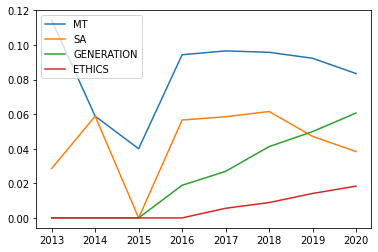

In [68]:
plot_category(["MT", "SA", "GENERATION", "ETHICS"], labels)

Should we trust these results as reflecting trends in the attention the ACL community gives to these topics?  Think about the potential biases that might exist in this method and the results, especially given your experience in creating this dataset.  Explore this model and data with whatever methods you think would help your argument -- e.g., try plotting a confusion matrix over the development data to see which classes are being confused, examine the data points that have the highest confidence wrong predictions, etc.).  How would you go about interrogating this method to know whether to trust these findings?  Submit your <200 word answer to this question as a PDF on gradescope.


In [143]:
# prediction labels for dev data
def getDevYPreds(model, x, y):
  model.eval()
  y_dev_preds = []
  with torch.no_grad():
    for x, y in zip(x, y):
      y_predicts = model.forward(x)
      y_dev_preds.append(torch.argmax(y_predicts, 1))
  return y_dev_preds

cnn_devY_preds = getDevYPreds(cnnmodel, cnn_devX, cnn_devY)
cnn_devY_preds

[tensor([14, 10, 17,  0,  0, 20,  4, 14, 21,  8,  0,  3]),
 tensor([ 0,  9,  3, 15,  8, 17,  6,  2, 12,  3,  3,  9]),
 tensor([16, 20, 20, 17, 21,  6,  3, 21,  3,  6,  4,  8]),
 tensor([14, 10, 11, 23, 10, 17, 14, 11,  2, 12, 21, 12]),
 tensor([20,  2,  0,  6,  4,  0,  0,  4, 24, 17,  6, 21]),
 tensor([ 0, 12, 16,  4,  0, 12,  4, 11, 18, 18, 10, 21]),
 tensor([14, 11, 20,  0, 13,  4,  0,  0,  3,  2,  8, 12]),
 tensor([21,  4,  6, 17, 12, 11, 10, 12, 10,  4, 12, 10]),
 tensor([17, 21, 11,  0,  7,  6,  0,  2,  0, 12, 18, 12]),
 tensor([ 6, 12,  0,  0,  0, 14, 16, 21,  6, 15, 17, 16]),
 tensor([ 8,  9,  4,  2,  3, 21, 18, 12,  4, 12, 11, 21]),
 tensor([ 0,  3,  0, 11,  0, 23,  0,  2,  2, 14, 17, 13]),
 tensor([ 1, 16,  2, 12, 14, 17, 14,  3,  3,  6, 21, 21]),
 tensor([ 2, 23, 14, 12,  3,  5,  9,  6,  2, 18, 20,  1]),
 tensor([20,  4,  9,  6,  3, 20,  6,  1, 19, 18,  6, 17]),
 tensor([21,  3, 18, 20, 14,  3,  6,  4, 10, 15, 13,  9]),
 tensor([18, 18, 17, 12,  0,  3,  6, 12, 12, 10,  2, 11]

In [144]:
# true labels for dev data
cnn_devY

[tensor([14,  7, 17,  1,  0, 20,  4, 15, 21, 23,  0,  4]),
 tensor([ 2,  2,  3, 15,  6, 17, 21,  2, 12,  3,  3,  9]),
 tensor([ 7,  0, 20, 17, 21,  1,  3, 21,  7,  6,  4,  8]),
 tensor([ 1,  8, 14, 23, 18,  6, 11, 23,  2, 12,  7, 18]),
 tensor([ 1,  2, 20, 11,  4, 15,  0,  4,  1,  9,  6, 21]),
 tensor([15, 12,  0,  0,  7,  3,  4,  7, 18,  6,  8,  1]),
 tensor([ 7,  2, 20,  0, 13,  4,  7, 20, 14,  2, 23, 12]),
 tensor([21,  4,  6,  3, 12, 11,  5, 12, 22,  4, 15, 20]),
 tensor([17, 21, 23, 24,  2,  6,  2,  2, 10, 12, 18, 12]),
 tensor([ 6,  1,  7,  7,  2, 14, 16, 16,  1, 17, 17, 18]),
 tensor([ 8,  5,  4,  0,  1, 11, 18, 12,  4, 17, 23, 21]),
 tensor([20, 24,  0,  2,  0, 11,  0,  2,  2,  6, 17, 17]),
 tensor([11, 16,  2, 14,  1, 17, 14,  3,  8,  6,  1, 11]),
 tensor([20, 12, 17, 12, 16,  5,  9,  6,  2,  0,  1,  1]),
 tensor([10,  4, 20,  6,  3, 20, 14, 22, 24, 10, 20, 17]),
 tensor([ 1,  3, 18,  1, 23,  2,  6,  4, 15,  1, 13,  9]),
 tensor([18, 18, 17, 12,  0,  5, 11,  9,  9,  8,  2, 18]

In [157]:
# flatten the list of tensors to a long tensor
preds = torch.cat(cnn_devY_preds, dim=0)
trus = torch.cat(cnn_devY, dim=0)

In [190]:
import tensorflow.math as tfmath

In [191]:
# confusion matrix
cm = tfmath.confusion_matrix(trus, preds, num_classes=26)

In [182]:
# print confusion matrix with tensor, source code: https://deeplizard.com/learn/video/0LhiS6yu2qQ
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    # thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white")
    # if cm[i, j] > thresh else "black"
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tf.Tensor(
[[11  0  2  1  1  0  0  0  0  0  0  0  0  0  0  0  2  1  1  0  1  0  0  0
   0  0]
 [ 2  4  0  1  0  0  2  0  0  0  3  1  1  0  4  1  1  0  0  0  4  7  0  0
   1  0]
 [ 3  0 14  1  1  0  0  1  0  2  0  2  0  0  0  0  1  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  1  0  0
   0  0]
 [ 0  0  1  1 26  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0
   0  0]
 [ 1  0  0  2  0  1  0  0  0  1  1  0  0  0  0  0  0  0  0  1  1  0  0  0
   0  0]
 [ 0  0  0  0  0  0 17  0  1  2  0  1  0  0  1  0  0  2  1  0  0  0  0  0
   0  0]
 [ 4  0  0  1  0  0  0  1  0  0  1  1  0  0  3  0  1  0  0  0  0  1  0  0
   0  0]
 [ 0  1  0  1  1  0  0  0  3  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  1  0  0  0  0  4  1  0  2  0  0  0  0  1  0  0  0  0  0  0
   0  0]
 [ 2  0  0  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0  0
   0  0]
 [ 1  1  0  0  1  0  2  0  0  0  0  

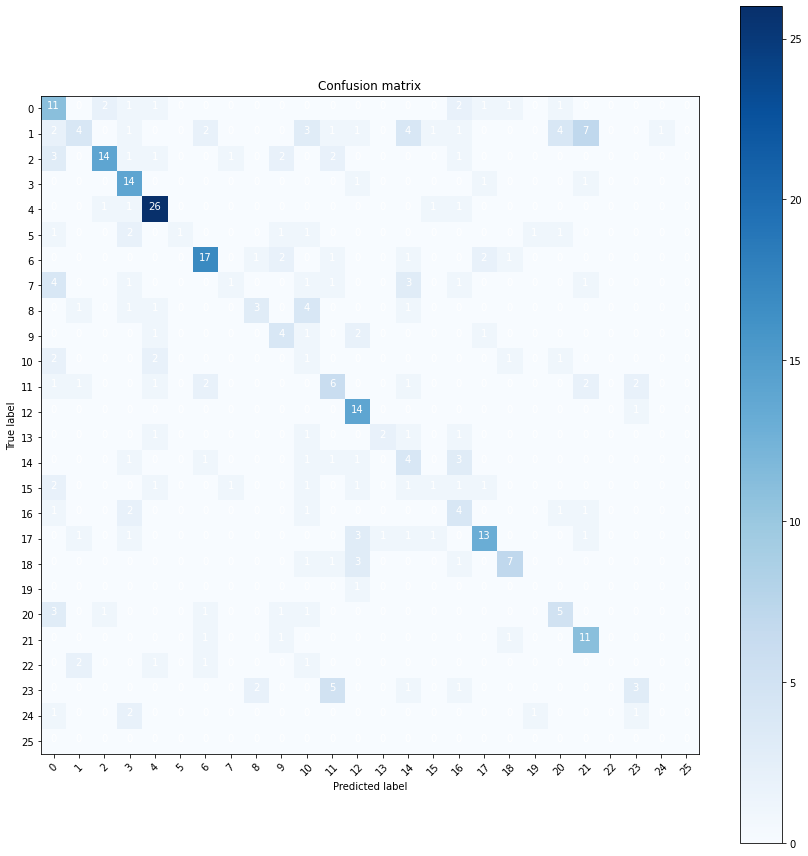

In [183]:
plot_confusion_matrix(cm, classes=range(0,26))

In [189]:
reverse_labels

{0: 'SENTSEM',
 1: 'MLCLASS',
 2: 'SUMM',
 3: 'MULTILING',
 4: 'MT',
 5: 'PHON',
 6: 'IE',
 7: 'LEXSEM',
 8: 'ETHICS',
 9: 'GENERATION',
 10: 'INTERPRET',
 11: 'APPLICATIONS',
 12: 'DIALOGUE',
 13: 'DISCOURSE',
 14: 'RESOURCES',
 15: 'GREEN',
 16: 'MLLM',
 17: 'QA',
 18: 'GROUNDING',
 19: 'SPEECH',
 20: 'SYNTAX',
 21: 'SA',
 22: 'IR',
 23: 'CSSCA',
 24: 'LING',
 25: 'OTHER'}